In [1]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project/Optimized_model
/home/ladans/DNN/Project/Optimized_model/Dataset


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, Flatten, RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
# Directory containing CSV files
data_dir = dir_base  

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path)
    df['Stock_Symbol'] = stock_symbol
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])

# Normalize prices using MinMaxScaler across all stocks
scaler = MinMaxScaler(feature_range=(0, 1))
all_data['Normalized_Close'] = all_data.groupby('Stock_Symbol')['Close'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

all_data.head()

,Date,Open,Close,Stock_Symbol,Stock_Index,Normalized_Close
0,2012-09-04,95.108574,96.424286,AAPL,0,0.375340
1,2012-09-05,96.510002,95.747147,AAPL,0,0.369085
2,2012-09-06,96.167145,96.610001,AAPL,0,0.377055
3,2012-09-07,96.864288,97.205711,AAPL,0,0.382558
4,2012-09-10,97.207146,94.677139,AAPL,0,0.359201


In [21]:
# Parameters
sequence_length = 32  # Adjusted based on optimization

X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    normalized_prices = stock_data['Normalized_Close'].values

    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])

X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)

In [6]:
# Train-test split
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
train_size = int(len(X) * train_ratio)
validation_size = int(len(X) * validation_ratio)

# Perform the splits
X_train = X[:train_size]
y_train = y[:train_size]
stock_indices_train = stock_indices[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]
stock_indices_val = stock_indices[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]
stock_indices_test = stock_indices[train_size + validation_size:]

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print sizes for verification
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 3432
Validation samples: 735
Test samples: 737


In [7]:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size = 23  # Increased embedding size based on Optuna

from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Flatten, 
    RepeatVector, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define inputs
price_input = Input(shape=(sequence_length, 1), name="price_input")
stock_input = Input(shape=(1,), name="stock_input")

# Embedding layer for stock symbols
stock_embedding = Embedding(
    input_dim=num_stocks, 
    output_dim=16, 
    name="stock_embedding"
)(stock_input)
stock_embedding = Flatten()(stock_embedding)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)

# Merge price input and embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(merged_input)
lstm_out = Dropout(0.1)(lstm_out)  # Apply Dropout correctly
lstm_out = LSTM(64, return_sequences=True)(lstm_out)

# Final LSTM layer
final_out = LSTM(32, return_sequences=False)(lstm_out)

# Output layer
output = Dense(1, activation="linear", name="output")(final_out)

# Define the model
model = Model(inputs=[price_input, stock_input], outputs=output)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
history = model.fit(
    [X_train, stock_indices_train], y_train,
    validation_data=([X_val, stock_indices_val], y_val),
    epochs=50,
    batch_size=32,  # Adjust batch size for better performance
    verbose=1,
)

Epoch 1/50


W0000 00:00:1733322285.578108  799487 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  2/108 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1626

2024-12-04 14:24:47.794335: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0203 - val_loss: 0.0011
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0014 - val_loss: 9.1923e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 9.2810e-04 - val_loss: 9.6396e-04
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 8.6436e-04 - val_loss: 8.0762e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 8.3249e-04 - val_loss: 0.0011
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 8.0184e-04 - val_loss: 7.1849e-04
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 7.8405e-04 - val_loss: 7.0464e-04
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 7.5448e-04 - val_loss: 7.0994e-04
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.8664e-04 - val_loss: 6.7142e-04
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 6.1337e-04 - val_loss:

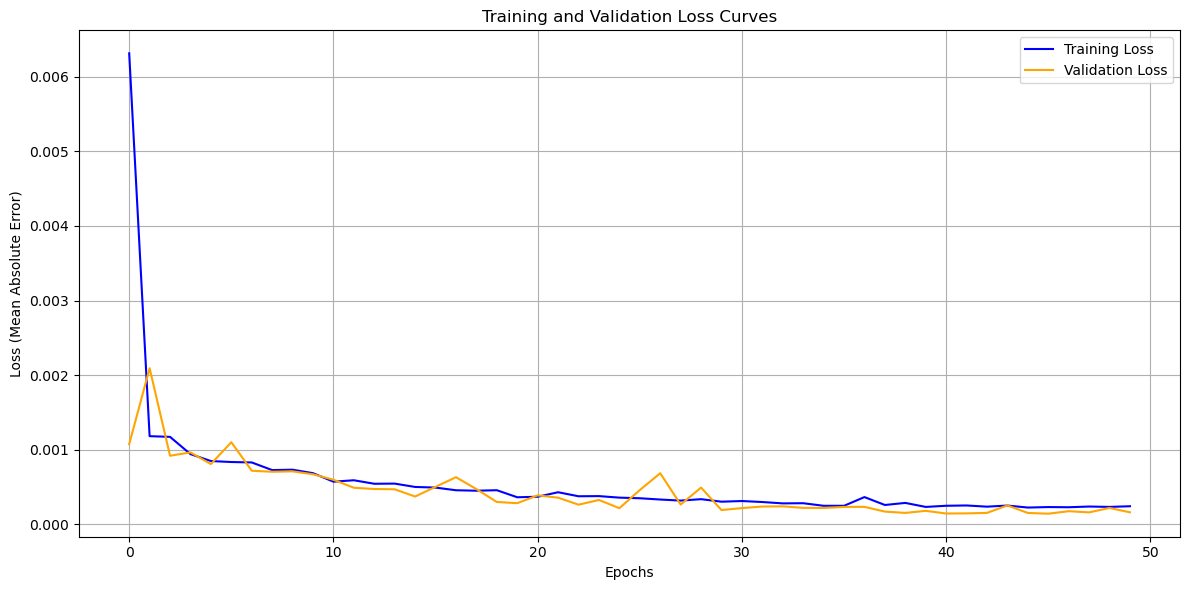

In [8]:
import matplotlib.pyplot as plt

# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_optimized')
plt.show()


In [9]:
#Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

# Denormalize predictions and actual values
def denormalize(values, stock_symbol):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_prices = all_data[all_data['Stock_Symbol'] == stock_symbol]['Close'].values
    scaler.fit(stock_prices.reshape(-1, 1))
    return scaler.inverse_transform(values.reshape(-1, 1)).flatten()

y_test_denormalized = np.concatenate([
    denormalize(y_test[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

predicted_prices_denormalized = np.concatenate([
    denormalize(predicted_prices[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

# Calculate metrics
mae = mean_absolute_error(y_test_denormalized, predicted_prices_denormalized)
mse = mean_squared_error(y_test_denormalized, predicted_prices_denormalized)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_denormalized - predicted_prices_denormalized) / y_test_denormalized)) * 100

print("MAE (Original Scale):", mae)
print("MSE (Original Scale):", mse)
print("RMSE (Original Scale):", rmse)
print("MAPE:", mape, "%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
MAE (Original Scale): 0.6038003152504746
MSE (Original Scale): 0.6673958031339181
RMSE (Original Scale): 0.8169429619832208
MAPE: 1.1482447069352621 %


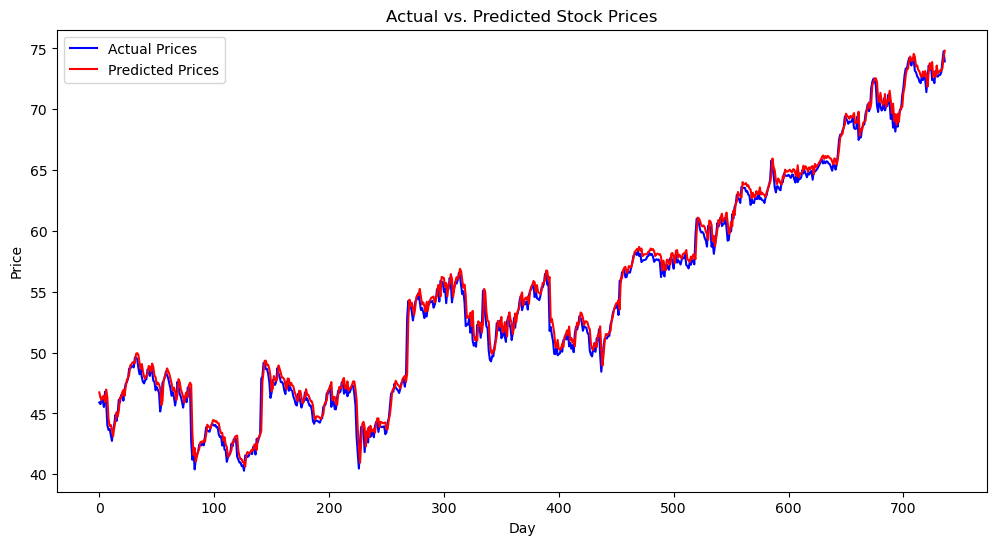

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.savefig('actual_prediction_optimized')
plt.show()

# Evaluate per-stock metrics
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae_reversed = mean_absolute_error(
        y_test_denormalized[stock_mask], predicted_prices_denormalized[stock_mask]
    )

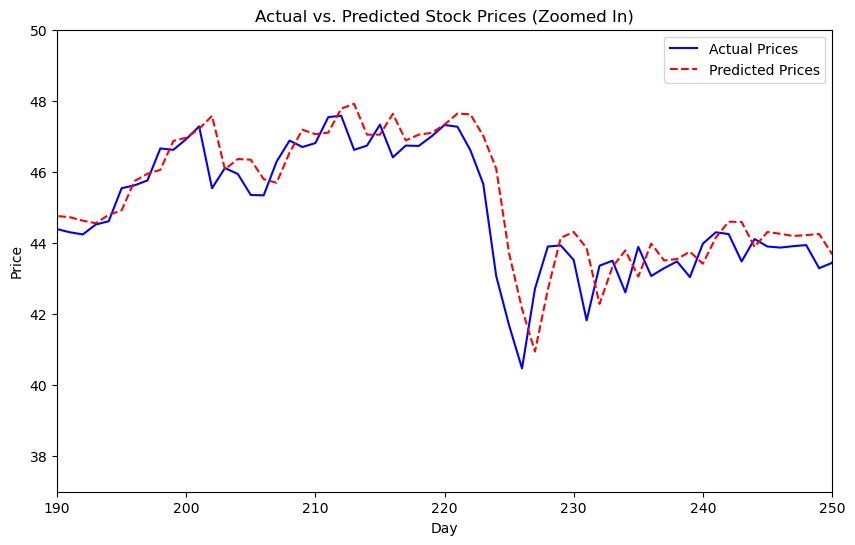

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red", linestyle='--')

# Set axis limits to zoom in on a specific section
plt.xlim(190, 250)  # Zoom into x-axis (e.g., focus on indices 100 to 200)
plt.ylim(37, 50)    # Zoom into y-axis (e.g., focus on prices between 40 and 60)

plt.title("Actual vs. Predicted Stock Prices (Zoomed In)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.savefig('zoomed')
plt.show()


In [ ]:
# Predict the next price for a new sequence
array_34_values = X_test[-1]  

# Reshape new_sequence to match the model's expected input shape
new_sequence = array_34_values.reshape((1, sequence_length, 1))

# Find the encoded index for the desired stock (e.g., MSFT)
stock_index = encoder.transform(['MSFT'])

# Predict the normalized price
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization to get the predicted price
predicted_price_original_scale = scaler.inverse_transform(predicted_normalized_price)[0][0]

print("Predicted next price for MSFT (original scale):", predicted_price_original_scale)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted next price for MSFT (original scale): 74.81433
